In [1]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
nsfg = h5py.File('nsfg.hdf5', 'r')

nsfg

<HDF5 file "nsfg.hdf5" (mode r)>

In [3]:
for key in nsfg.keys():
    print(key)

nsfg


In [4]:
group = nsfg['nsfg']

In [5]:
for key in group.keys():
    print(key)

axis0
axis1
block0_items
block0_values
block1_items
block1_values


In [6]:
col1_nsfg = nsfg['nsfg']['block0_items'][()]
col2_nsfg = nsfg['nsfg']['block1_items'][()]
data1_nsfg = nsfg['nsfg']['block0_values'][()]
data2_nsfg = nsfg['nsfg']['block1_values'][()]

In [7]:
tab1 = pd.DataFrame(data1_nsfg, columns=col1_nsfg)
tab2 = pd.DataFrame(data2_nsfg, columns=col2_nsfg)

In [8]:
nsfg = pd.concat([tab1, tab2], axis=1)

In [9]:
nsfg.columns = nsfg.columns.astype(str)

### Exploring the NSFG data

In [10]:
nsfg.shape

(9358, 10)

In [11]:
nsfg.columns

Index(['caseid', 'outcome', 'prglngth', 'agecon', 'birthwgt_lb1',
       'birthwgt_oz1', 'nbrnaliv', 'agepreg', 'hpagelb', 'wgt2013_2015'],
      dtype='object')

In [12]:
ounces = nsfg['birthwgt_oz1']

In [13]:
ounces.head()

0     4.0
1    12.0
2     4.0
3     NaN
4    13.0
Name: birthwgt_oz1, dtype: float64

### Clean a variable

In [14]:
nsfg['nbrnaliv'].replace(8, np.nan, inplace=True)
nsfg['nbrnaliv'].value_counts()

1.0    6379
2.0     100
3.0       5
Name: nbrnaliv, dtype: int64

In [15]:
agecon = nsfg['agecon']/100
agepreg = nsfg['agepreg']/100
preg_length = agepreg - agecon
preg_length.describe()

count    9109.000000
mean        0.552069
std         0.271479
min         0.000000
25%         0.250000
50%         0.670000
75%         0.750000
max         0.920000
dtype: float64

### Make a histogram

(array([   3.,    4.,    8.,   94.,  379.,  827., 1207., 1109., 1050.,
         945.,  898.,  726.,  648.,  547.,  365.,  256.,  155.,   83.,
          39.,   15.]),
 array([ 7.5,  9.3, 11.1, 12.9, 14.7, 16.5, 18.3, 20.1, 21.9, 23.7, 25.5,
        27.3, 29.1, 30.9, 32.7, 34.5, 36.3, 38.1, 39.9, 41.7, 43.5]),
 <a list of 20 Patch objects>)

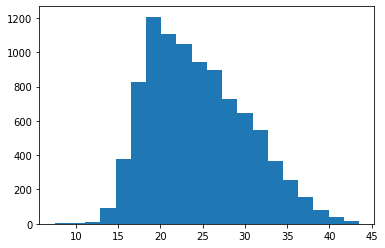

In [16]:
plt.hist(agecon, bins=20)

### Compute birth weight

In [17]:
def resample_rows_weighted(df, column='finalwgt', seed=17):
    """Resamples a DataFrame using probabilities proportional to given column.

    df: DataFrame
    column: string column name to use as weights

    returns: DataFrame
    """
    np.random.seed(seed)
    weights = df[column] / sum(df[column])
    indices = np.random.choice(df.index, len(df), replace=True, p=weights)
    sample = df.loc[indices]
    return sample

In [18]:
# Resample the data
nsfg = resample_rows_weighted(nsfg, 'wgt2013_2015')

# Clean the weight variables
pounds = nsfg['birthwgt_lb1'].replace([98, 99], np.nan)
ounces = nsfg['birthwgt_oz1'].replace([98, 99], np.nan)

# Compute total birth weight
birth_weight = pounds + ounces/16

In [19]:
full_term = nsfg['prglngth'] >= 37

# Select the weights of full-term babies
full_term_weight = birth_weight[full_term]

# Compute the mean weight of full-term babies
full_term_weight.mean()

7.392597951914515

### Filter

In [20]:
# Filter full-term babies
full_term = nsfg['prglngth'] >= 37

# Filter single births
single = nsfg['nbrnaliv'] == 1

# Compute birth weight for single full-term babies
single_full_term_weight = birth_weight[single & full_term]
print('Single full-term mean:', single_full_term_weight.mean())

# Compute birth weight for multiple full-term babies
mult_full_term_weight = birth_weight[~single & full_term]
print('Multiple full-term mean:', mult_full_term_weight.mean())

Single full-term mean: 7.40297320308299
Multiple full-term mean: 5.784722222222222
